In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import utils

In [20]:
!nvidia-smi


Wed Apr 10 12:04:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              31W /  70W |   4251MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
# define writer for tensorboard
writer = SummaryWriter()

In [22]:
torch.cuda.is_available()

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [23]:
# Define the mini-batch size
batch_size = 256 if torch.cuda.is_available() else 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224)
])

# Download the dataset and create the dataloaders
cifar_data = datasets.CIFAR10("./", train=True, download=True, transform=transform)

train_size = int(0.8 * len(cifar_data))
val_size = len(cifar_data)-train_size

cifar_train, cifar_val = torch.utils.data.random_split(cifar_data, [train_size, val_size])

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False)

cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=transform)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
# fine tuning
model_ft = models.alexnet(pretrained=True)
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch 0, training loss: 0.003186308065801859, validation loss: 0.0022913685649633407
Train accuracy = 0.7162
Validation accuracy = 0.7998
Epoch 5, training loss: 0.0006678597139194608, validation loss: 0.0015629278182983399
Train accuracy = 0.939875
Validation accuracy = 0.8761
Epoch 10, training loss: 0.000264525724214036, validation loss: 0.0014828231409192085
Train accuracy = 0.976575
Validation accuracy = 0.8987
Epoch 15, training loss: 0.0001322534997249022, validation loss: 0.001846072018146515
Train accuracy = 0.98865
Validation accuracy = 0.8887


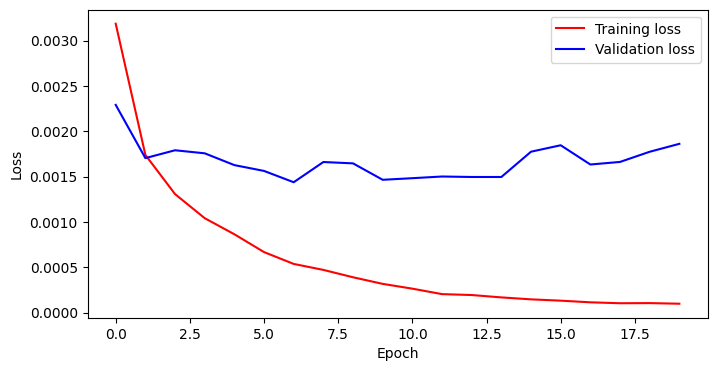

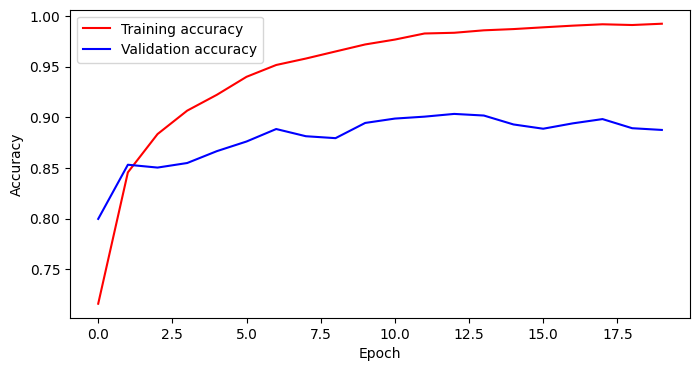

lowest loss for validation set: 0.001438177143037319, with an accuracy of 0.8884


In [25]:
# Do the things required for fine-tuning before training the model
# modifying last layer to our need
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 10)

model_ft.to(device)

LEARNING_RATE = 0.0001
EPOCHS = 20

# Define our loss function
criterion_ft = nn.CrossEntropyLoss()

# Define our optimizer
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

# Train the model
utils.train_model(model_ft, criterion_ft, optimizer_ft, train_loader, val_loader,"best_model_fine_tuning.pt",writer, EPOCHS, device)

Test accuracy is 89.0%.


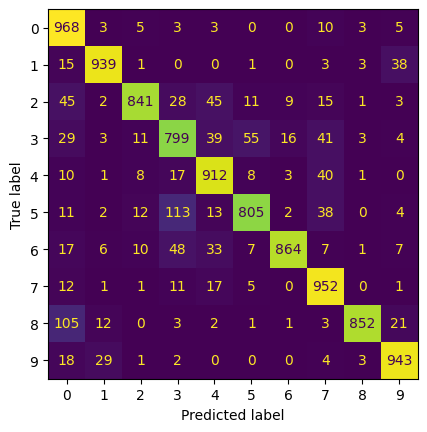

In [26]:
# Test the model
best_model = torch.load('best_model_fine_tuning.pt')
best_model.to(device)

utils.test_model(best_model, test_loader, device)

Epoch 0, training loss: 0.01614746546447277, validation loss: 0.0080862628698349
Train accuracy = 0.135775
Validation accuracy = 0.3017
Epoch 5, training loss: 0.004860293641686439, validation loss: 0.0045356342673301695
Train accuracy = 0.568125
Validation accuracy = 0.6197
Epoch 10, training loss: 0.004421425303816795, validation loss: 0.004111827379465103
Train accuracy = 0.6029
Validation accuracy = 0.6527
Epoch 15, training loss: 0.004244164039194584, validation loss: 0.003926106423139572
Train accuracy = 0.6248
Validation accuracy = 0.6668


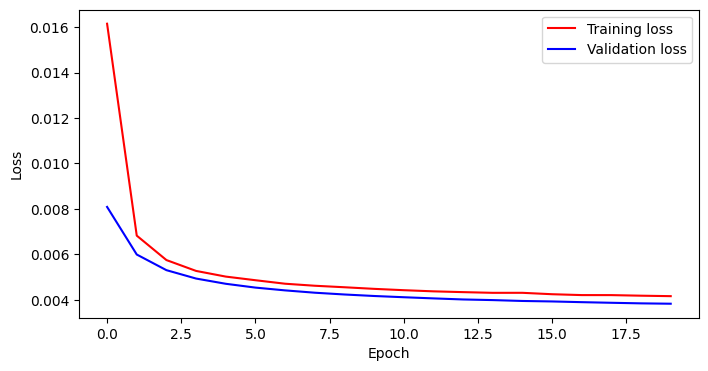

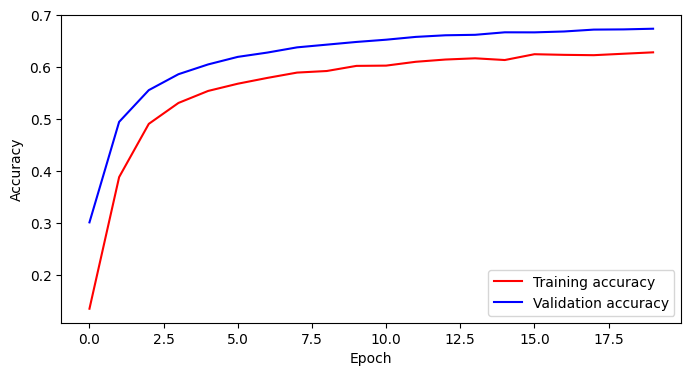

lowest loss for validation set: 0.003826008379459381, with an accuracy of 0.6738


In [28]:
# Use a predefined model as a feature extractor
model_fe = models.alexnet(pretrained=True)

# freeze all layers
for param in model_fe.parameters():
    param.requires_grad = False

# Do the things required for fine-tuning before training the model
LEARNING_RATE = 0.0001
EPOCHS = 20

# modify last layer to our needs
num_ftrs = model_fe.classifier[6].in_features
model_fe.fc = nn.Linear(num_ftrs, 10)

# Unfreeze last layer
for param in model_fe.classifier[6].parameters():
    param.requires_grad = True

model_fe.to(device)

# Define our loss function
criterion_fe = nn.CrossEntropyLoss()

# Define our optimizer
optimizer_fe = torch.optim.Adam(model_fe.parameters(), lr=LEARNING_RATE)

# Train the model
utils.train_model(model_fe, criterion_fe, optimizer_fe, train_loader, val_loader,'best_model_feature_extraction.pt',writer, EPOCHS, device)

Test accuracy is 68.0%.


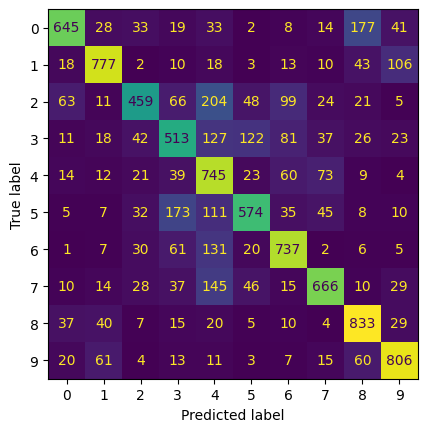

In [29]:
# Test the model
best_model = torch.load('best_model_feature_extraction.pt')
best_model.to(device)
utils.test_model(best_model, test_loader, device)